## Library

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from torch.utils.data import Dataset
from torch.utils.data import random_split
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Subset
from tqdm import tqdm
from datetime import datetime
import torch.nn.functional as F

/home/azarius/envs/hse-proj-py38/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
!pwd

/home/azarius/Projects


In [7]:
# from google.colab import drive
# drive.mount('/content/drive')

In [8]:
!ls /content/drive/MyDrive/iad_project/

ls: cannot access '/content/drive/MyDrive/iad_project/': No such file or directory


## Data Plot

In [2]:
data = pd.read_csv('./tinkoff-data/AMZN.csv')

In [3]:
data.head()

,open,high,low,close,volume,time
0,1790.20,1790.20,1790.20,1790.20,5,2019-12-23 07:06:00+00:00
1,1788.59,1788.64,1788.59,1788.64,2,2019-12-23 07:11:00+00:00
2,1788.66,1788.66,1788.66,1788.66,2,2019-12-23 07:13:00+00:00
3,1790.10,1790.10,1787.30,1787.30,2,2019-12-23 07:27:00+00:00
4,1787.30,1787.30,1787.30,1787.30,1,2019-12-23 07:29:00+00:00


In [4]:
data.shape

(414894, 6)

In [5]:
# data['unix_time'] = data.time.apply(lambda x: (datetime.strptime(x[:-6], '%Y-%m-%d %H:%M:%S') - datetime(1970, 1, 1)).total_seconds())

In [6]:
data.drop(columns=['time'], inplace=True)

In [7]:
data = data.astype('float32')

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414894 entries, 0 to 414893
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   open    414894 non-null  float32
 1   high    414894 non-null  float32
 2   low     414894 non-null  float32
 3   close   414894 non-null  float32
 4   volume  414894 non-null  float32
dtypes: float32(5)
memory usage: 7.9 MB


In [16]:
data.head(10)

,open,high,low,close,volume
0,206.899994,206.899994,206.899994,206.899994,1.0
1,206.100006,206.100006,206.100006,206.100006,1.0
2,204.899994,204.899994,204.899994,204.899994,8.0
3,205.000000,205.000000,205.000000,205.000000,1.0
4,205.000000,205.000000,205.000000,205.000000,41.0
5,205.000000,205.000000,205.000000,205.000000,5.0
6,205.000000,205.000000,205.000000,205.000000,3.0
7,205.000000,205.000000,204.940002,204.940002,16.0
8,205.300003,205.300003,205.199997,205.199997,41.0
9,205.130005,205.990005,205.130005,205.990005,12.0


In [17]:
# data.iloc[0].unix_time

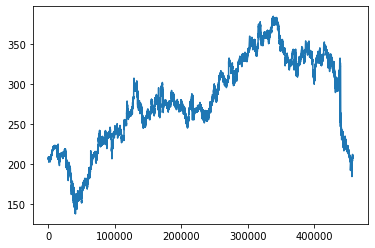

In [18]:
plt.plot(data.close.values)

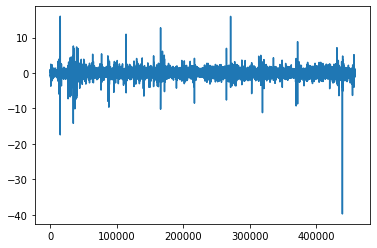

In [19]:
plt.plot(data.close.diff().values)
plt.show()

## Dataloading

In [9]:
class TsCNNDataset(Dataset):
    def __init__(self, raw_data_df, window_size):
        self.raw_data_df = raw_data_df[['open', 'high', 'low', 'volume', 'close']]#, 'unix_time']]
        self.window_size = window_size

    def __len__(self):
        return self.raw_data_df.shape[0] - self.window_size

    def __getitem__(self, idx):
        start = idx
        end = idx + self.window_size
        # return self.raw_data_df.iloc[start:end].values, self.raw_data_df.iloc[end]['close']
        return torch.tensor(np.swapaxes(self.raw_data_df.iloc[start:end].diff().dropna().values, 0, 1)), torch.tensor(self.raw_data_df.iloc[end].values), torch.tensor(self.raw_data_df.iloc[end-1].values)
        # return [self.raw_data_df.iloc[start:end]['open'].values, self.raw_data_df.iloc[start:end]['high'].values, self.raw_data_df.iloc[start:end]['low'].values, self.raw_data_df.iloc[start:end]['close'].values, self.raw_data_df.iloc[start:end]['volume'].values, self.raw_data_df.iloc[start:end]['unix_time'].values], self.raw_data_df.iloc[end]['close']

In [10]:
class TsLSTMDataset(Dataset):
    def __init__(self, raw_data_df, window_size):
        self.raw_data_df = raw_data_df[['open', 'high', 'low', 'volume', 'close']]
        self.window_size = window_size

    def __len__(self):
        return self.raw_data_df.shape[0] - self.window_size

    def __getitem__(self, idx):
        start = idx
        end = idx + self.window_size
        return self.raw_data_df.iloc[start:end].diff().dropna().values, self.raw_data_df.iloc[end].values, self.raw_data_df.iloc[end-1].values

## Model

In [11]:
class tsLSTM(nn.Module):

    def __init__(self, n_features, n_hidden=128, n_layers=2):
        super().__init__()
        
        self.n_hidden = n_hidden
        
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            batch_first=True,
            num_layers=n_layers#,
#             dropout=0.2
        )
        
        self.regressor = nn.Linear(n_hidden, 5)
        
    def forward(self, x):
#         self.lstm.flattern_parameters()
        
        _, (hidden, _) = self.lstm(x)
        
        return self.regressor(hidden[-1])

class tsCNN(nn.Module):

    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(5, 15, 6)
        self.pool = nn.MaxPool1d(3)
        self.conv2 = nn.Conv1d(15, 30, 6)
        self.conv3 = nn.Conv1d(30, 100, 3)
#         self.conv4 = nn.Conv1d(30, 40, 3)
        self.fc1 = nn.Linear(200, 60)
        self.fc2 = nn.Linear(60, 10)
        self.fc3 = nn.Linear(10, 5)

    def forward(self, x):
        # print(x.shape)
        # bias = x[:-1:-1]
        # print(bias.shape)
        # print(bias)
        # x = torch.diff(x)
        # print('input', x.shape)
        x = self.conv1(x)
        x = F.relu(x)
        # print('conv1', x.shape)
        x = self.pool(x)
        # print('pool1', x.shape)

        x = self.conv2(x)
        x = F.relu(x)
        # print('conv2', x.shape)
        x = self.pool(x)
        # print('pool2', x.shape)

        x = self.conv3(x)
        x = F.relu(x)
        # print('conv3', x.shape)
#         x = self.pool(x)
        # print('pool3', x.shape)

#         x = self.conv4(x)
#         x = F.relu(x)
        # print('conv3', x.shape)
#         x = self.pool(x)
        # print('pool3', x.shape)
        x = torch.flatten(x, 1)
        # print('flatten', x.shape)

        x = self.fc1(x)
        x = F.relu(x)
        # print('fc1', x.shape)

        x = self.fc2(x)
        x = F.relu(x)
        # print('fc2', x.shape) 

        x = self.fc3(x)
        return x# + bias

        # x = self.pool(F.relu(self.conv2(x)))
        # x = torch.flatten(x, 1) # flatten all dimensions except batch
        # x = F.relu(self.fc1(x))
        # x = F.relu(self.fc2(x))
        # x = self.fc3(x)
        # return x
        

In [34]:
class TSPredictor():
              
    def __init__(self, needLoad = False, path_to_model=None, model_type = None, window_size=3600):
        self.window_size = window_size
        self.isModelrained = False
        self.model_type = model_type
        self.y_true = None
        self.y_pred = None
        
        self.max_plt = None
        self.min_plt = None
        
        if needLoad:

            if model_type == 'CNN':
                self.model = tsCNN()

            if model_type == 'LSTM':
                self.model = tsLSTM(n_features=5)
                
            self.model.load_state_dict(torch.load(path_to_model))
            self.model.eval()
            self.isModelrained = True

        else:
            if model_type == 'CNN':
                self.model = tsCNN()
            if model_type == 'LSTM':
                self.model = tsLSTM(n_features=5)
  
    def train(self, num_epochs = 5, learning_rate=0.01, data_df=None, test_split=0.15, BATCH_SIZE = 512):
        
        test_start_idx = data_df.shape[0] - int(data_df.shape[0]*test_split)
        self.min_plt = data_df.close.min()
        self.max_plt = data_df.close.max()
        
        print('preprocess data')
        if self.model_type == 'CNN':
            dataset = TsCNNDataset(data_df, self.window_size)
        if self.model_type == 'LSTM':
            dataset = TsLSTMDataset(data_df, self.window_size)

        train_split = Subset(dataset, range(test_start_idx))
        test_split = Subset(dataset, range(test_start_idx, len(dataset)))
        train_batches = DataLoader(train_split, batch_size=BATCH_SIZE, shuffle=False)
        test_batches = DataLoader(test_split, batch_size=BATCH_SIZE, shuffle=False)
        criterion = torch.nn.MSELoss()
        optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
        self.model.to('cuda');

        for epoch in range(num_epochs):
            self.y_true = data_df.close.values.copy()
            self.y_pred = data_df.close.values.copy()
            i = self.window_size
            tepoch = tqdm(train_batches, unit="batch")
            self.model.train()
            for inputs, targets, bias in tepoch:
                # break
#                 print(inputs.shape)
                inputs = inputs.to('cuda')
                targets = targets.to('cuda')
#                 print('bias.shape')
#                 print(bias.shape)
#                 bias = torch.unsqueeze(bias, 1)
                bias = bias.to('cuda')
                optimizer.zero_grad()
                pred = self.model(inputs)
#                 print('pred.shape')
#                 print(pred.shape)

                pred = pred + bias
                loss = criterion(pred, targets)

                pred = pred.detach().cpu().numpy()
                # print(pred)
                # print(bias.detach().cpu().numpy().shape)
                # assert False
                self.y_pred[i:i+pred.shape[0]] = pred[:, -1].flatten().copy()
                # print(i)
                # print(i + pred.flatten().shape[0])
                # print(pred.flatten().shape)

                i += pred.shape[0]
                # print(i)
                # assert False

                tepoch.set_description("loss: « %s »" % str(loss.detach().cpu().numpy()))
                loss.backward()
                optimizer.step()

            tepoch = tqdm(test_batches, unit="batch")
            self.model.eval()
            optimizer.zero_grad()
            for inputs, targets, bias in tepoch:
                inputs = inputs.to('cuda')
                targets = targets.to('cuda')
#                 bias = torch.unsqueeze(bias, 1)
                bias = bias.to('cuda')
                pred = self.model(inputs)
                pred = pred + bias

                pred = pred.detach().cpu().numpy()
                # print(pred.flatten())
                self.y_pred[i:i+pred.shape[0]] = pred[:, -1].flatten().copy()
                i += pred.shape[0]         

            plt.axvline(x=test_start_idx, c='r', linestyle='--')
            plt.ylim(self.min_plt, self.max_plt)

            plt.plot(self.y_pred, color='orange')
            plt.plot(self.y_true, color='blue')

            plt.suptitle('Time-Series Prediction')
            plt.show()


        self.model.eval()
        self.model.to('cpu')
        self.isModelrained = True

    def save_model(self, path):
        self.model.eval()
        self.model.to('cpu')
        torch.save(self.model.state_dict(), path)
        self.isModelrained = True
        print('model saved to ' + path)    
    
    def inference_df(self, df, device_str):
        device = torch.device('cuda:0') if device_str=='gpu' else torch.device('cpu')
        self.model.to(device)
        
        if not self.isModelrained:
            print('model is not trained')
            return None
        else:
            if df.shape[0] != self.window_size:
                print('incorrect input df shape')
                return None
            else:
                bias = df.values[-1]
                data = df[['open', 'high', 'low', 'volume', 'close']].diff().dropna()
                vals = data.values

                if self.model_type == 'CNN':
                    vals = np.swapaxes(vals, 0, 1)
                vals = np.expand_dims(vals, axis=0)
                
                
#                 print(vals.shape)
                pred = self.model(torch.tensor(vals).to(device)).detach().cpu().numpy()[0]
#                 print('pred')
#                 print(pred)
#                 print('bias')
#                 print(bias)
                return pred + bias
  
    def inference_far_period(self, df, ticks, device_str):
        new_df = df.copy()
        for i in tqdm(range(ticks-1)):
            pred = self.inference_df(new_df, device_str)
            print(pred)
            new_df = pd.concat([new_df[1:], pd.DataFrame.from_dict({'open':[pred[0]],
                                                           'high':[pred[1]],
                                                           'low':[pred[2]],
                                                           'volume':[pred[3]],
                                                           'close':[pred[4]]})], ignore_index=True)
        return self.inference_df(new_df, device_str)

  

In [56]:
# predictor = TSPredictor(needLoad=True, model_type='CNN', path_to_model='./FB_CNN.pt')

In [22]:
torch.cuda.empty_cache()

In [21]:
predictor = None

In [23]:
predictor = TSPredictor(needLoad=False, model_type='CNN', window_size=60)

In [59]:
data.head()

,open,high,low,close,volume
0,206.899994,206.899994,206.899994,206.899994,1.0
1,206.100006,206.100006,206.100006,206.100006,1.0
2,204.899994,204.899994,204.899994,204.899994,8.0
3,205.000000,205.000000,205.000000,205.000000,1.0
4,205.000000,205.000000,205.000000,205.000000,41.0


preprocess data


100%|██████████████████████████████████████████| 4/4 [00:33<00:00,  8.46s/batch]


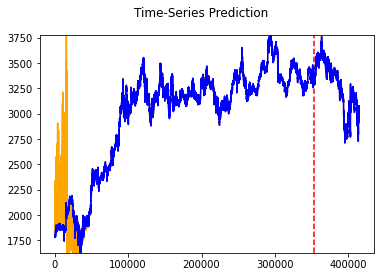

In [24]:
predictor.train(data_df=data, num_epochs=1, BATCH_SIZE=16384)#192 4096)

In [25]:
y_true = predictor.y_true
y_pred = predictor.y_pred

In [26]:
mean_absolute_error(y_true, y_pred)

5.9964733

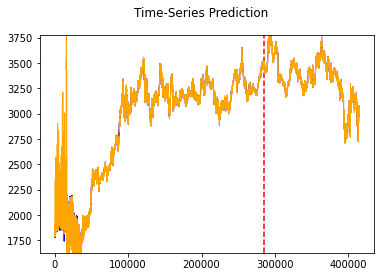

In [27]:
plt.axvline(x=285016, c='r', linestyle='--')
plt.ylim(predictor.min_plt, predictor.max_plt)

plt.plot(y_true, color='blue', linewidth=1)
plt.plot(y_pred, color='orange', linewidth=1)


plt.suptitle('Time-Series Prediction')
plt.show()

In [35]:
predictor = TSPredictor(needLoad=True, model_type='CNN', path_to_model='./AMZN_CNN.pt', window_size=60)

In [37]:
predictor.inference_far_period(data[:60], 60, 'gpu')

100%|██████████████████████████████████████████| 59/59 [00:00<00:00, 423.04it/s]

[1791.213    1791.1271   1791.0286   1790.7611      9.925243]
[1791.426    1791.2542   1791.0571      9.686392 1790.6864  ]
[1791.639    1791.3812   1791.0857   1790.4475      9.611635]
[1791.852    1791.5083   1791.1143      9.372784 1790.3728  ]
[1792.0651   1791.6354   1791.1428   1790.1339      9.298027]
[1792.2781    1791.7625    1791.1714       9.0591755 1790.0592   ]
[1792.4911   1791.8895   1791.2      1789.8203      8.984419]
[1792.7041   1792.0166   1791.2285      8.745567 1789.7456  ]
[1792.9171   1792.1437   1791.2571   1789.5067      8.670811]
[1793.1301   1792.2708   1791.2856      8.431959 1789.432   ]
[1793.3431   1792.3978   1791.3142   1789.1931      8.357203]
[1793.5562   1792.5249   1791.3428      8.118351 1789.1184  ]
[1793.7692   1792.652    1791.3713   1788.8795      8.043594]
[1793.9822    1792.779     1791.3999       7.8047433 1788.8048   ]
[1794.1952    1792.9061    1791.4285    1788.5659       7.7299867]
[1794.4082    1793.0332    1791.457        7.4911356 17

array([1.8037808e+03, 1.7986245e+03, 1.7927139e+03, 5.9176362e-01,
       1.7815920e+03], dtype=float32)

In [29]:
predictor.save_model('./AMZN_CNN.pt')

model saved to ./AMZN_CNN.pt


In [116]:
8192 * 2

16384

AMZN
preprocess data


100%|██████████████████████████████████████████| 4/4 [00:32<00:00,  8.15s/batch]


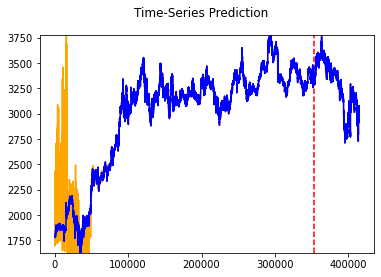

model saved to ./AMZN_CNN.pt
preprocess data


loss: « 11929401.0 »:  22%|███▎           | 403/1837 [00:41<02:28,  9.63batch/s]


KeyboardInterrupt: 

In [123]:
predictor = None
torch.cuda.empty_cache()

for ticker in ['AMZN', 'AAPL', 'FB', 'GOOGL', 'GOOG', 'MSFT', 'NVDA', 'TSLA']:
    print(ticker)
    for mdl_type, batch_size in [('CNN', 16384), ('LSTM', 192)]:
        data =  pd.read_csv('./tinkoff-data/' + ticker + '.csv')
        data.drop(columns=['time'], inplace=True)
        data = data.astype('float32')
        predictor = TSPredictor(needLoad=False, model_type=mdl_type, window_size=60)
        predictor.train(data_df=data, num_epochs=1, BATCH_SIZE=batch_size)
        predictor.save_model('./' + ticker + '_' + mdl_type + '.pt')
        predictor = None
        torch.cuda.empty_cache()

In [66]:
y_true = predictor.y_true
y_pred = predictor.y_pred

In [30]:
from sklearn.metrics import mean_absolute_error

In [67]:
mean_absolute_error(y_true, y_pred)

0.22005692

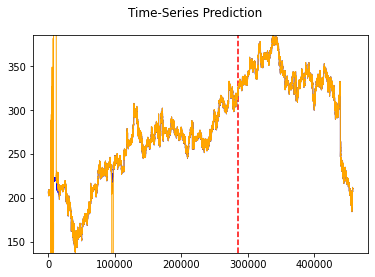

In [33]:
plt.axvline(x=285016, c='r', linestyle='--')
plt.ylim(predictor.min_plt, predictor.max_plt)

plt.plot(y_true, color='blue', linewidth=1)
plt.plot(y_pred, color='orange', linewidth=1)


plt.suptitle('Time-Series Prediction')
plt.show()

In [ ]:
# counter = 0
# for i in range(len(y_true)):
#     if y_pred[i] != y_true[i]:
#         counter += 1
# #         print(i, y_pred[i], y_true[i])
# #     if i > 100:
# #         break
# print(counter)
# print(len(y_true))

In [35]:
predictor.isModelrained = True

In [37]:
predictor.model.to('cpu')

tsCNN(
  (conv1): Conv1d(5, 10, kernel_size=(360,), stride=(1,))
  (pool): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(10, 20, kernel_size=(360,), stride=(1,))
  (conv3): Conv1d(20, 30, kernel_size=(120,), stride=(1,))
  (conv4): Conv1d(30, 40, kernel_size=(10,), stride=(1,))
  (fc1): Linear(in_features=400, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
  (fc3): Linear(in_features=10, out_features=5, bias=True)
)

In [94]:
predictor = TSPredictor(needLoad=True, model_type='LSTM', path_to_model='./FB_LSTM.pt')

In [95]:
predictor.inference_df(data[:3600])

pred
[-9.0685412e-03 -2.8249785e-02 -2.4828199e-02  1.0997315e+02
 -2.4723599e-02]
bias
[209.75 209.75 209.7  209.7    4.  ]


array([209.74094  , 209.72176  , 209.67517  , 319.67316  ,   3.9752765],
      dtype=float32)

In [43]:
data

,open,high,low,close,volume
0,206.899994,206.899994,206.899994,206.899994,1.0
1,206.100006,206.100006,206.100006,206.100006,1.0
2,204.899994,204.899994,204.899994,204.899994,8.0
3,205.000000,205.000000,205.000000,205.000000,1.0
4,205.000000,205.000000,205.000000,205.000000,41.0
...,...,...,...,...,...
457776,210.259995,210.259995,210.259995,210.259995,13.0
457777,210.100006,210.259995,210.100006,210.259995,5.0
457778,210.259995,210.259995,210.240005,210.240005,7.0
457779,210.190002,210.190002,210.399994,210.399994,108.0


In [53]:
np.swapaxes(np.expand_dims(data[:3600].diff().dropna().values, axis=0), 1, 2).shape

(1, 5, 3599)

In [69]:
predictor.model(torch.tensor(np.swapaxes(np.expand_dims(data[:3600].diff().dropna().values, axis=0), 1, 2)))

RuntimeError: input.size(-1) must be equal to input_size. Expected 5, got 3599

In [74]:
predictor.model(torch.tensor(np.expand_dims(data[:3600].diff().dropna().values, axis=0))).cpu().detach().numpy()[0]

array([-8.8264912e-02,  6.0212016e-03, -8.3648756e-02, -1.8402092e+02,
       -6.6040851e-02], dtype=float32)

In [ ]:
# predictor.save_model('/content/drive/MyDrive/iad_project/LSTM.pt')

In [ ]:
# data[:3600].close.diff().shape

In [ ]:
# data[:3600].close

In [ ]:
# data[:3600].close.diff().dropna()

In [ ]:
# 86.300003 - 86.699997